# CMSE 202 Honors Project: 
## Road Marker Identification
James Kervin </br>
Fall 2022 

### Goals:

The goal of this project are to create a method for taking in an image and finding the right hand road line vector. Or a directional line that follows the white right hand line of the road.
</br></br>
**Assuptions**<br>
To create these algorithums a few key assumptions are made in this project to simpilfy the proccess:
1. It is assumed that in every picture there is a road with a white line. 
2. It is assumed that the picture protrays an accurate RGB values of the current road. 
</br>
**Limitations**</br>
Besides the assumptions there are a few key limitations on this project. 
1. The images are taken from random online sources and not all from the same camera. This means that the contrast and brighteness may vary largely between images
2. Not all images have the same angle to the road. This impacts the features that are usable, because the angle to the road changes the angle of the road off to the distance changes. Therefore frequency of adjecent pixels varys too much to be used as a impactful feature.

### Needed Libraries

In [1]:
#for displaying and resizing
from PIL import Image

#for array manipulation
import numpy as np

#graphing diplays
import matplotlib.pyplot as plt

#for SVM
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#for recoding run time
import time
from datetime import datetime


#for data organization and display
import pandas as pd

#this is for storing the svm
import pickle


#created functions to handle image manipulation easier
from ImageReaders import BringInImages, Collect_key_matrix, Reconstruct


from LineCreation import CreateRightLineEquation

In [2]:
#this is used to choose wether or not to retrain the SVM or load the pickel file
Retrain_SVM = True

## Bring in Road Image

To begin the process the road image must first be brought in. When brining in the image the qaulity can be stepped down. Becuase the goal is to get the dirrection vector not every pixel of the white line is needed this reduction in quality allows for an increase in speed as well. 

In [3]:
#this is used to control the resolution of the picture
train_accuracy = 0.35
accuracy = 0.22

New Pixels: 29400 (105 i x 280 j)
Original Pixels: 240000 (300 i x 800 j)
Percent of pixels used 12.250 %


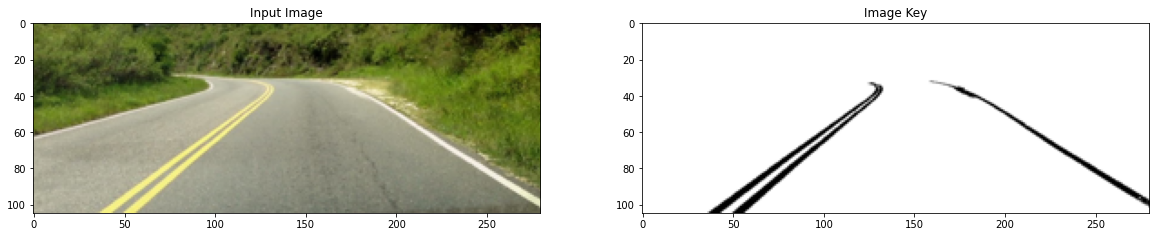

In [4]:
Road, key = BringInImages(r"Images/Road1.jpg", r"Keys/Road1_key.jpg", train_accuracy)

## Break Down Key and Image into Features

Now with the RGB image brought in the features of the image can be pulled apart and placed into a matrix. For each pixel the red, green, blue, yellow, and white values are considered. Each one of these is then in turn normalized to reduce any large scale difference.  

In [5]:
def GetAtributes(image, ShowTime = False):
    '''This function will condense a RGB image to a set of features
    Returns: 3D array, features 2D array, Dataframe for easier display
    '''
    start = time.time()
    
    image_arr = np.array(image)
    features_arr = []
    
    for i in range(0,len(image_arr)):
        for j in range(0,len(image_arr[0])):
            R, G, B = image_arr[i,j]
            
            #convert data types to proctect against overflow
            R = int(R)
            G = int(G)
            B = int(B)
            
            #Yellow
            Y = R+G
            
            #white
            W = R+G+B
            
            
            features_arr.append([R, G, B, Y, W])
    
    
    if ShowTime:
        end = time.time()
        s = "Time to extract features: {:.2f} seconds".format(end - start)
        print(s)
    return image_arr, features_arr

The features that are used are shown in the image below 

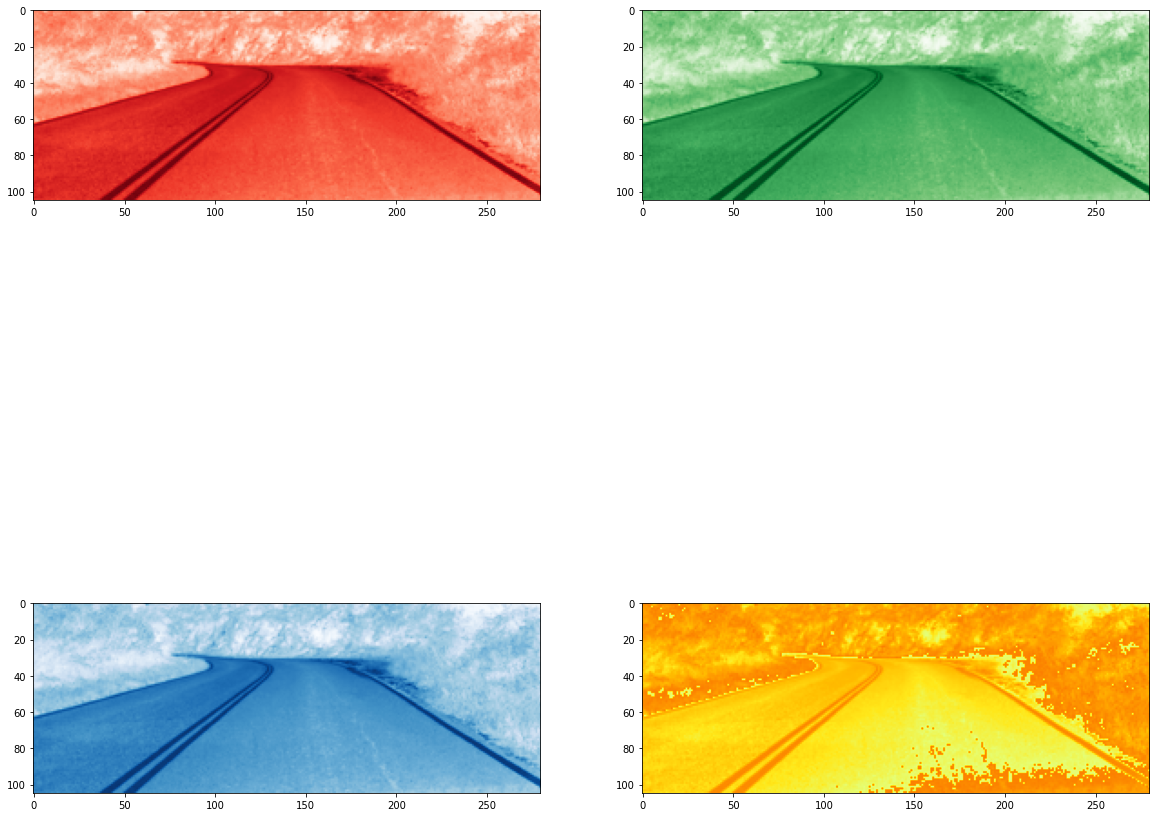

In [6]:
#Show features

fig, ax = plt.subplots(2, 2)
Road_arr = np.array(Road)
  
# draw graph
fig.set_figwidth(20)
fig.set_figheight(20)
ax[0, 0].imshow(Road_arr[:,:,0], cmap = 'Reds')
ax[0][1].imshow(Road_arr[:,:,1], cmap = 'Greens')
ax[1][0].imshow(Road_arr[:,:,0], cmap = 'Blues')
ax[1][1].imshow(Road_arr[:,:,0]+Road_arr[:,:,1], cmap = 'Wistia')

In [7]:
Road_arr, Road_features= GetAtributes(Road, True)

Time to extract features: 0.11 seconds


## Bring in the key

For this project keys needed to be created for each image. To do this a simple photo editor was used to draw a white background and black highlights over the road lines. Using this black and white RGB key image, a new matrix could be created where white pixels are chagned to 0 and black pixels are changed to 1. 

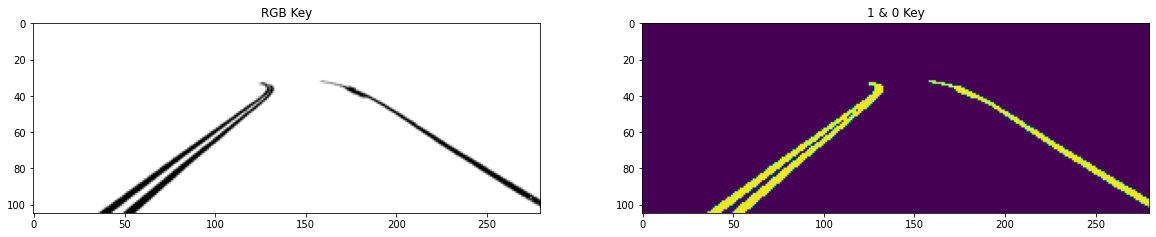

In [8]:
#bring in the key
key_arr, key_image, key_indecies = Collect_key_matrix(key, show = True)

## Create the SVM model

With the key and image features collected an Support Vector Machine can then be trained to identify which pixels are and which pixels aren't road line markers. 

In [9]:
start = time.time()

#split the data
train_vects, test_vects, train_labels, test_labels = train_test_split(Road_features, key_arr)

#create and fit model
svc_model = SVC(C = 100, gamma = 0.005)
svc_model.fit(train_vects, train_labels)

#get the score
score = svc_model.score(train_vects, train_labels)
print("Score: {:.2f} %".format(score*100))

#add run time
end = time.time()
sec_diff = end - start
s = "Run time: {} minutes and {:.2f} seconds".format(sec_diff%60, sec_diff- 60*sec_diff%60)
print(s)

Score: 99.31 %
Run time: 4.058694362640381 minutes and 0.54 seconds


In [10]:
predict_vectors = test_vects
true_labels = test_labels

pred_labels = svc_model.predict(predict_vectors)
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7060
           1       0.87      0.84      0.86       290

    accuracy                           0.99      7350
   macro avg       0.93      0.92      0.92      7350
weighted avg       0.99      0.99      0.99      7350



In [11]:
def testWithPicture(Image_path, Key_path , model, accuracy, showAccuracy = True,  ShowTime = True):
    '''Used to test the result of a model and a test image'''
    start = time.time()
    
    #bring in the image
    Road, key = BringInImages(Image_path, Key_path, accuracy, show = False)
    Road_arr, Road_features = GetAtributes(Road)
    key_arr, key_image, key_indecies = Collect_key_matrix(key)
    
    #find what the model predicts
    predict_vectors = Road_features
    pred_labels = model.predict(predict_vectors)
    
    if showAccuracy:
        true_labels = key_arr
        print(classification_report(true_labels, pred_labels))
    
    #reconstruct the image
    key_reconstruct = Reconstruct(pred_labels, len(key_image), len(key_image[0]))
    
    
    end = time.time()
    sec_diff = end - start
    s = "Run time: {} minutes and {:.2f} seconds".format(sec_diff%60, sec_diff- 60*sec_diff%60)
    
    if ShowTime:
        print("Time to bring in and predict image: {:.2f}".format(end-start))
    
    #display results
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    
    

    plt.subplot(1,2,1)
    plt.title("Orignal Image")
    plt.imshow(Road)
    
    plt.subplot(1,2,2)
    plt.title("SVM predicted Markers")
    plt.imshow(key_reconstruct)

    plt.show()

    return key_reconstruct

## Train image with model

From the above scores we can see that the model is very accurate with the train image, finding near a .99 weighted average. The reconstructed version can be seen when tested below.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11092
           1       0.91      0.74      0.82       524

    accuracy                           0.99     11616
   macro avg       0.95      0.87      0.91     11616
weighted avg       0.98      0.99      0.98     11616

Time to bring in and predict image: 0.84


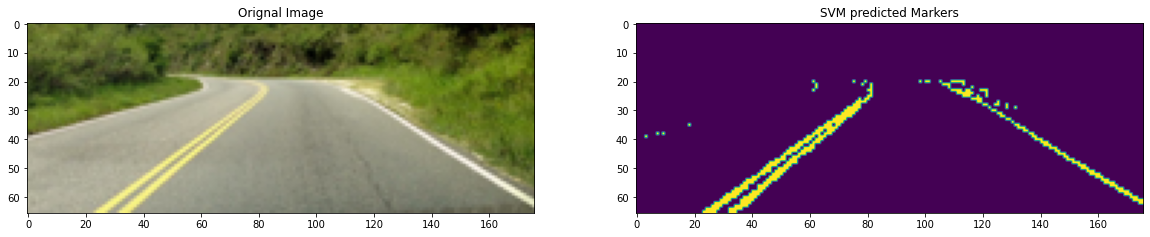

In [12]:
A = testWithPicture(r"Images/Road1.jpg", r"Keys/Road1_key.jpg", svc_model, accuracy)

## Test model with new images 
Now the model must be tested with new images. As can be seen from the two examples bellow, the model is good with very similar images to the train image, however are very inaccuate with new settigns around the road

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11273
           1       1.00      0.18      0.31       343

    accuracy                           0.98     11616
   macro avg       0.99      0.59      0.65     11616
weighted avg       0.98      0.98      0.97     11616

Time to bring in and predict image: 0.84


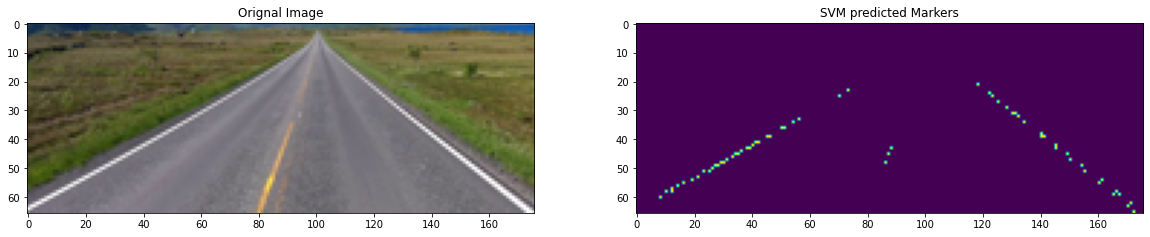

In [13]:
A = testWithPicture(r"Images/Road2.jpg", r"Keys/Road2_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     11211
           1       0.05      0.06      0.05       405

    accuracy                           0.92     11616
   macro avg       0.51      0.51      0.51     11616
weighted avg       0.93      0.92      0.93     11616

Time to bring in and predict image: 0.85


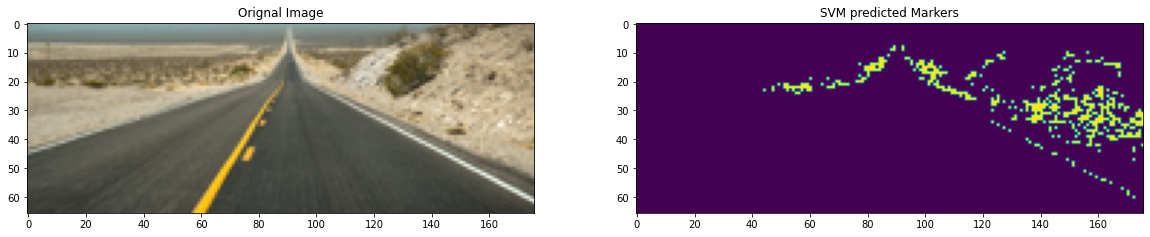

In [14]:
A = testWithPicture(r"Images/Road3.jpg", r"Keys/Road3_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11351
           1       0.05      0.01      0.01       265

    accuracy                           0.97     11616
   macro avg       0.51      0.50      0.50     11616
weighted avg       0.96      0.97      0.96     11616

Time to bring in and predict image: 0.85


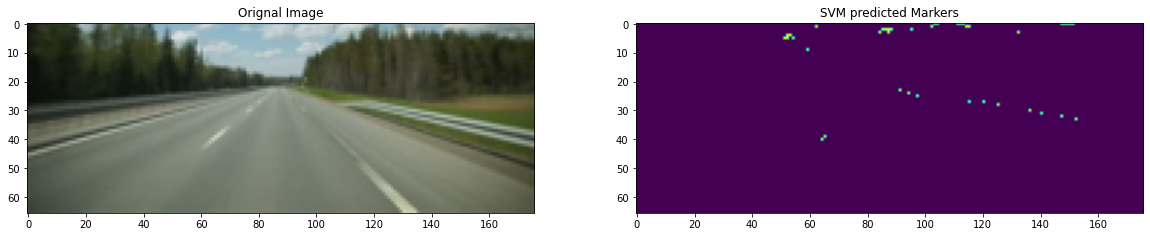

In [15]:
A = testWithPicture(r"Images/Road4.jpg", r"Keys/Road4_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11193
           1       0.00      0.00      0.00       423

    accuracy                           0.96     11616
   macro avg       0.48      0.50      0.49     11616
weighted avg       0.93      0.96      0.95     11616

Time to bring in and predict image: 0.87


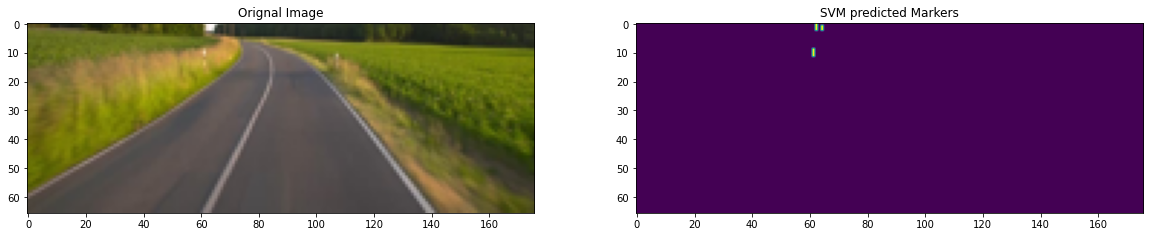

In [16]:
A = testWithPicture(r"Images/Road5.jpg", r"Keys/Road5_key.jpg", svc_model, accuracy)

## SVM created with 4 pictures of data in training data

In attempt to improve the model we then increase the training data set to be a combination of 4 different photos. With this training set a model can be trained. This model takes substaintially longer to train so the pickel library is used to store the model for later compliations

In [17]:
#bring in image 1
Road1, key1 = BringInImages(r"Images/Road1.jpg", r"Keys/Road1_key.jpg", train_accuracy, show= False)
Road1_arr, Road1_features = GetAtributes(Road1)
key1_arr, key1_image, key_indecies = Collect_key_matrix(key1)


#bring in image2
Road2, key2 = BringInImages(r"Images/Road3.jpg", r"Keys/Road3_key.jpg", train_accuracy, show = False)
Road2_arr, Road2_features = GetAtributes(Road2)
key2_arr, key2_image, key_indecies = Collect_key_matrix(key2)


#bring in image3
Road3, key3 = BringInImages(r"Images/Road6.jpg", r"Keys/Road6_key.jpg", train_accuracy, show = False)
Road3_arr, Road3_features = GetAtributes(Road3)
key3_arr, key3_image, key_indecies = Collect_key_matrix(key3)

#bring in image4
Road4, key4 = BringInImages(r"Images/Road8.jpg", r"Keys/Road8_key.jpg", train_accuracy, show = False)
Road4_arr, Road4_features = GetAtributes(Road3)
key4_arr, key4_image, key_indecies = Collect_key_matrix(key3)

#create combined data set
Road_features = []

#combine feature
for i in Road1_features:
    Road_features.append(i)
for i in Road2_features:
    Road_features.append(i)
for i in Road3_features:
    Road_features.append(i)
for i in Road4_features:
    Road_features.append(i)

#combine keys
key_arr = []
for i in key1_arr:
    key_arr.append(i)
for i in key2_arr:
    key_arr.append(i)
for i in key3_arr:
    key_arr.append(i)
for i in key4_arr:
    key_arr.append(i)


In [18]:
svc_model = None
filename = 'Maker_SVM.p'




if Retrain_SVM:
    
    now = datetime.now()
    current_time = now.strftime("%H:%M")
    print("Fiting started at: ", current_time)
    

    start = time.time()

    #create model with two images of data
    svc_model = SVC(C = 50, gamma = 0.0005)
    svc_model.fit(Road_features, key_arr)

    #show its score once again
    score = svc_model.score(train_vects, train_labels)
    print("Score: {:.2f} %".format(score*100))

    #add run time
    end = time.time()
    s = "Run time: {:.2f} seconds".format(end - start)
    print(s)
    
    pickle.dump(svc_model, open(filename, 'wb'))
    
else:
    print("reading pickle file.")
    svc_model = pickle.load(open(filename, 'rb'))
    print("model imported")
    
    print("on inital Run:")
    print("Score: 98.89 %")
    print("Run time: 61.45 seconds")

Fiting started at:  23:47
Score: 98.80 %
Run time: 36.39 seconds


## Show Train images used on model

With the new model we first use it to predict the images it is trained with. As expected it is very much more accuate with these images.

Time to bring in and predict image: 1.85


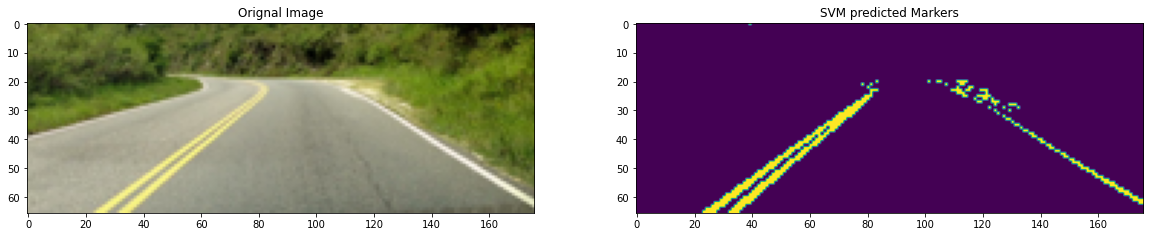

In [19]:
A = testWithPicture(r"Images/Road1.jpg", r"Keys/Road1_key.jpg", svc_model, accuracy, showAccuracy = False)

Time to bring in and predict image: 1.84


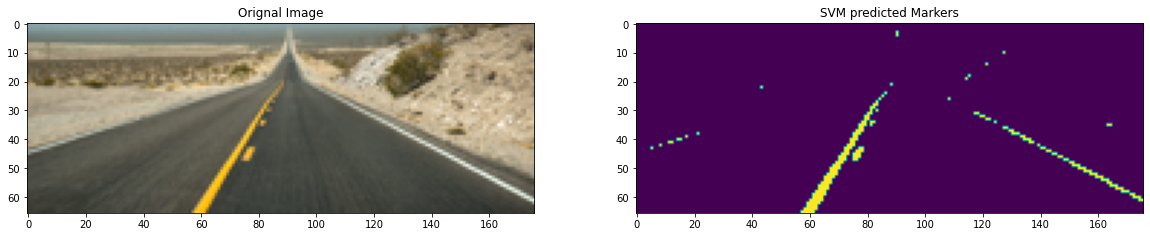

In [20]:
A = testWithPicture(r"Images/Road3.jpg", r"Keys/Road3_key.jpg", svc_model, accuracy,  showAccuracy = False)

Time to bring in and predict image: 1.84


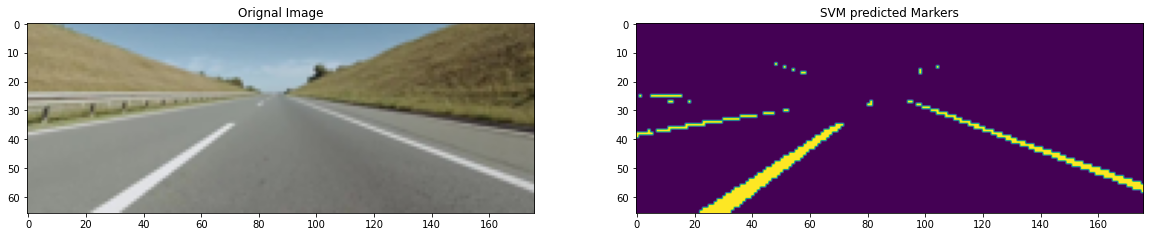

In [21]:
A = testWithPicture(r"Images/Road6.jpg", r"Keys/Road6_key.jpg", svc_model, accuracy,  showAccuracy = False)

Time to bring in and predict image: 1.81


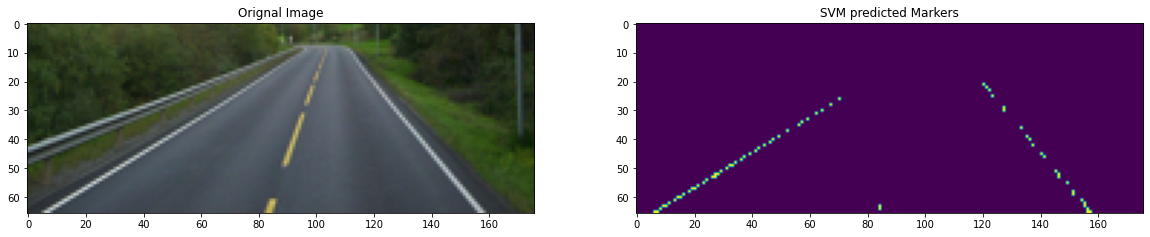

In [22]:
A = testWithPicture(r"Images/Road7.jpg", r"Keys/Road7_key.jpg", svc_model, accuracy, showAccuracy = False)

## New images tested with the new model

With this new model we then test with new images to see how the model will react to new data. As is expected it is much better with new data than the 1 image training set. However, this model is still not perfect and very sensitve to white and yellow on the outsides of the roads. 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11273
           1       0.91      0.65      0.76       343

    accuracy                           0.99     11616
   macro avg       0.95      0.82      0.88     11616
weighted avg       0.99      0.99      0.99     11616

Time to bring in and predict image: 1.84


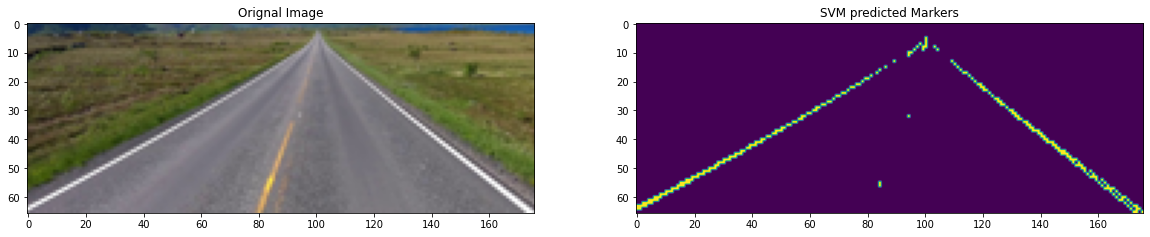

In [23]:
A = testWithPicture(r"Images/Road2.jpg", r"Keys/Road2_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11351
           1       0.07      0.06      0.06       265

    accuracy                           0.96     11616
   macro avg       0.52      0.52      0.52     11616
weighted avg       0.96      0.96      0.96     11616

Time to bring in and predict image: 1.84


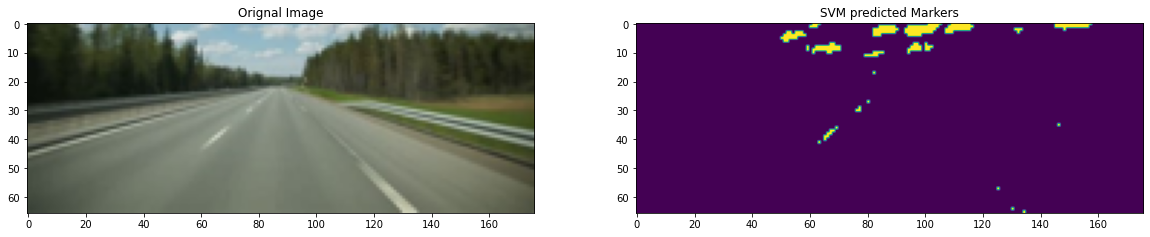

In [24]:
A = testWithPicture(r"Images/Road4.jpg", r"Keys/Road4_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     11193
           1       0.02      0.04      0.02       423

    accuracy                           0.88     11616
   macro avg       0.49      0.47      0.48     11616
weighted avg       0.93      0.88      0.90     11616

Time to bring in and predict image: 1.95


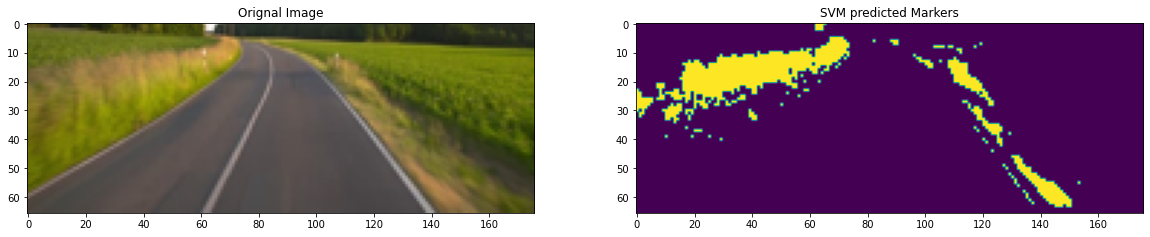

In [25]:
A = testWithPicture(r"Images/Road5.jpg", r"Keys/Road5_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     11167
           1       0.07      0.12      0.09       449

    accuracy                           0.90     11616
   macro avg       0.51      0.53      0.52     11616
weighted avg       0.93      0.90      0.91     11616

Time to bring in and predict image: 1.86


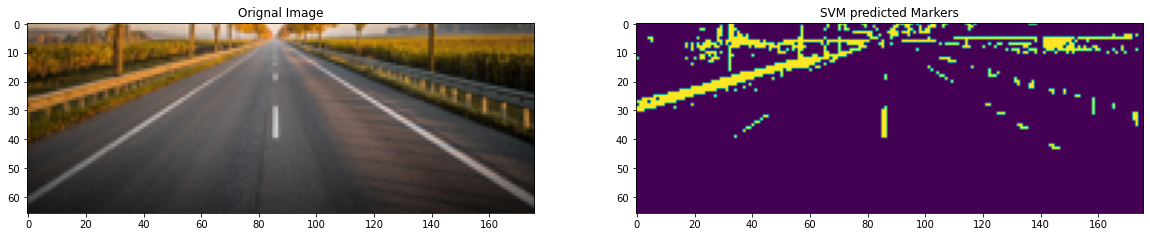

In [26]:
A = testWithPicture(r"Images/Road8.jpg", r"Keys/Road8_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11168
           1       0.74      0.31      0.43       448

    accuracy                           0.97     11616
   macro avg       0.86      0.65      0.71     11616
weighted avg       0.96      0.97      0.96     11616

Time to bring in and predict image: 1.88


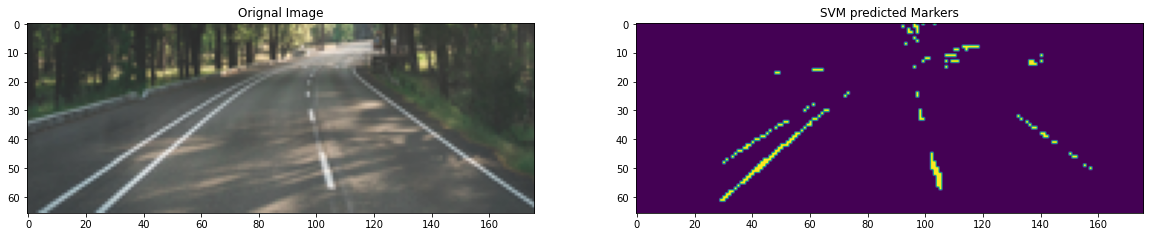

In [27]:
A = testWithPicture(r"Images/Road9.jpg", r"Keys/Road9_key.jpg", svc_model, accuracy)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11273
           1       0.66      0.34      0.45       343

    accuracy                           0.98     11616
   macro avg       0.82      0.67      0.72     11616
weighted avg       0.97      0.98      0.97     11616

Time to bring in and predict image: 1.84


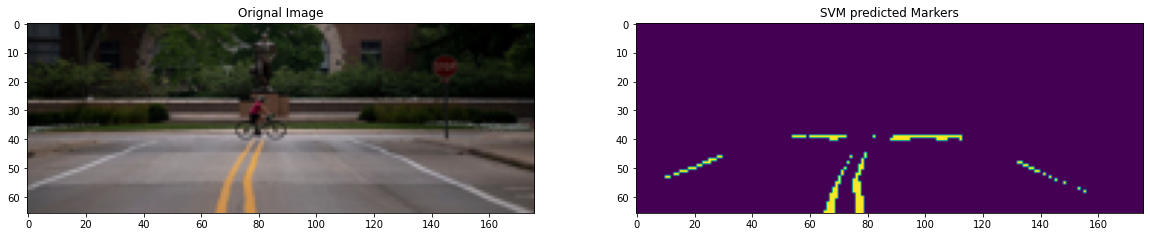

In [28]:
A = testWithPicture(r"Images/Road10.jpg", r"Keys/Road10_key.jpg", svc_model, accuracy)

## Right hand line Vector 

With the a model for finding the road lines created we can then apply a gap finding method to create the right hand line vector. To do this a function was create that first collects all of the i,j indeces of the svm results. This list of results is then organized based on the x index. With the organized list the furthest right point is considered the starting point of the right hand line. These starting point can be problimatic but this was chosen based on the assumption that the car will keep the right hand line very close to the edge of its feild of vision.
</br></br>
Next from here the algorithum steps left until it finds a gap of 5 inbetween the two key indices. This gap is assumed ot be the jump from the right hand line to the median. This jump is missing in some instances where the road comes to a point off in the distance. Instead of breaking the system assumes the line to end at the middle of key indices. This also solves images with so much noise that there is no gap in the image. 
</br></br>
Below the results of the SVM and right hand vector method are displayed. The vertical orange line show the start point and the vertical blue line shows the end point. The green vector is the right hand line vector. 

In [29]:
def plotRight_hand(image_path, key_path, model, accuracy):
    SVM_predicted_image = testWithPicture(image_path,key_path, model, accuracy, showAccuracy = False)
    slope, b, X_lBound, Y_lBound,  X_rBound, Y_rBound = CreateRightLineEquation(SVM_predicted_image)


    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)
    plt.axvline(X_lBound)
    plt.axvline(X_rBound, color = 'orange')
    plt.imshow(SVM_predicted_image)

    plt.arrow(X_rBound, Y_rBound, X_lBound-X_rBound, Y_lBound-Y_rBound, color='g', 
              head_width = 2, length_includes_head= True, width = 1)
    plt.show()
    

## Results

Time to bring in and predict image: 1.85


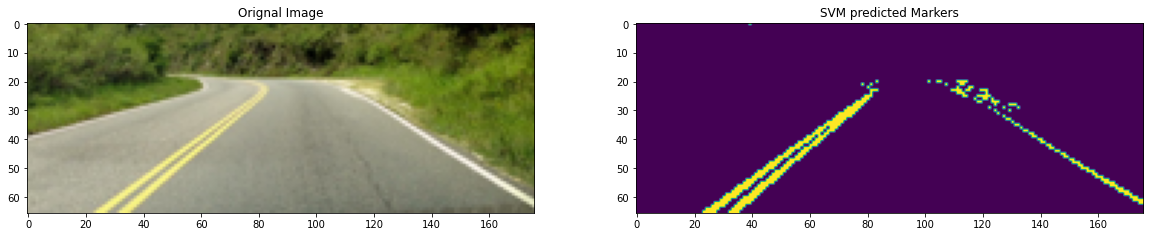

Left Bound: (101,20)
Rigth Bound: (175,62)
line angle -29.58 degrees
vector Equation
Slope: 0.57
B intercept: -37.32


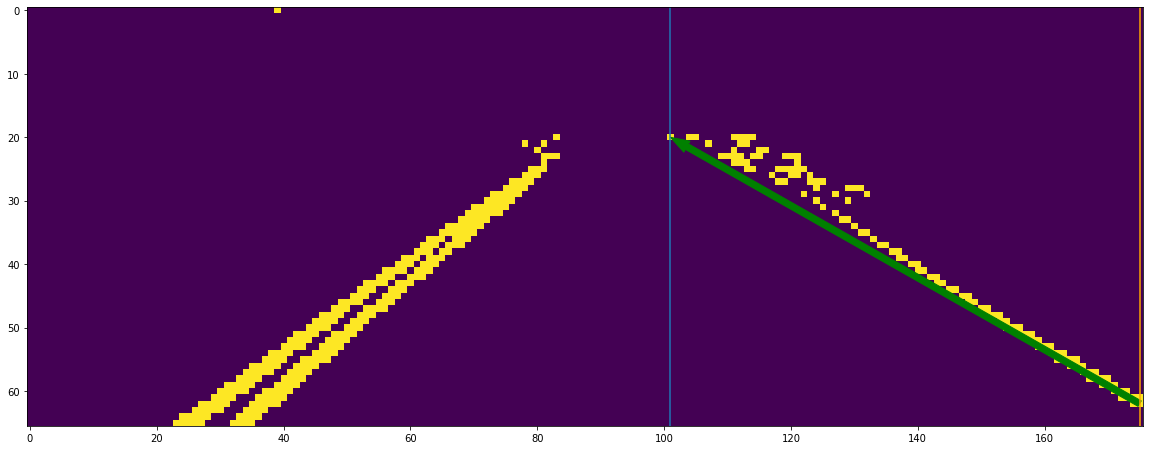

In [30]:
plotRight_hand(r"Images/Road1.jpg", r"Keys/Road1_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.82


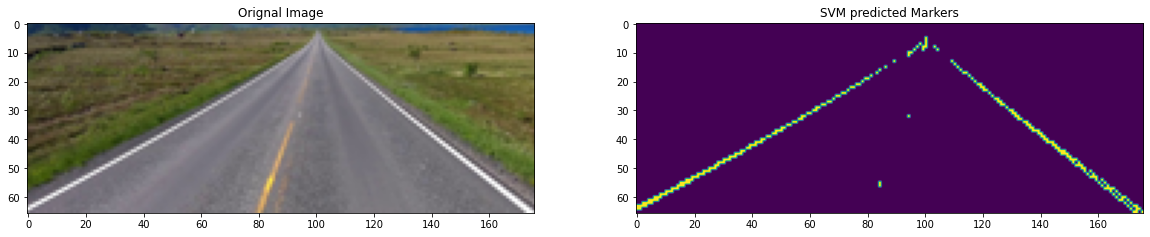

Left Bound: (109,13)
Rigth Bound: (175,65)
line angle -38.23 degrees
vector Equation
Slope: 0.79
B intercept: -72.88


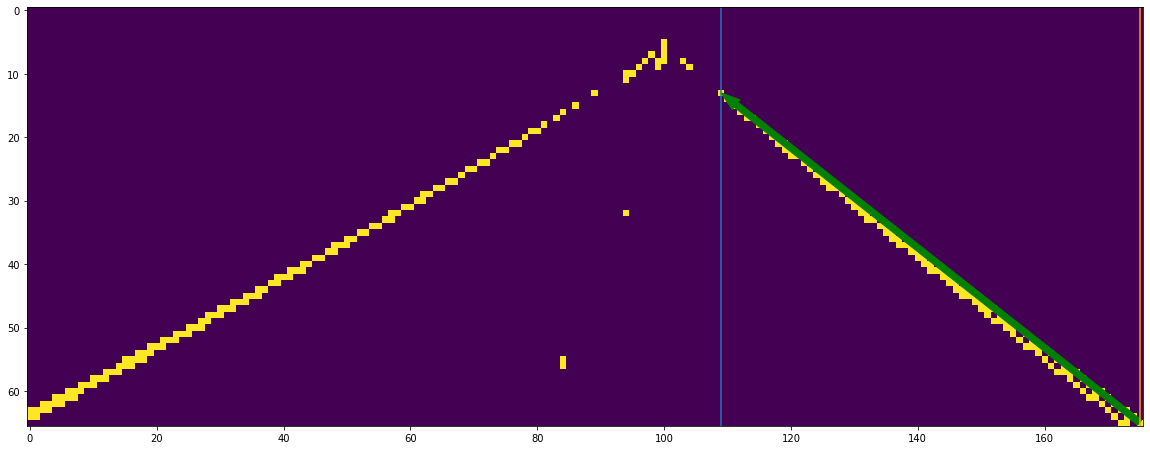

In [31]:
plotRight_hand(r"Images/Road2.jpg", r"Keys/Road2_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.82


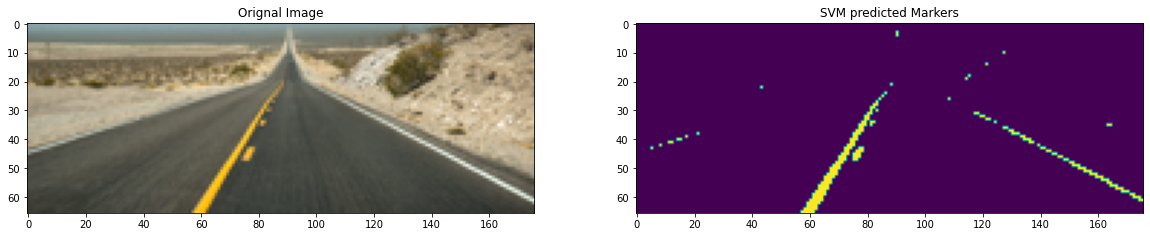

Left Bound: (114,19)
Rigth Bound: (175,61)
line angle -34.55 degrees
vector Equation
Slope: 0.69
B intercept: -59.49


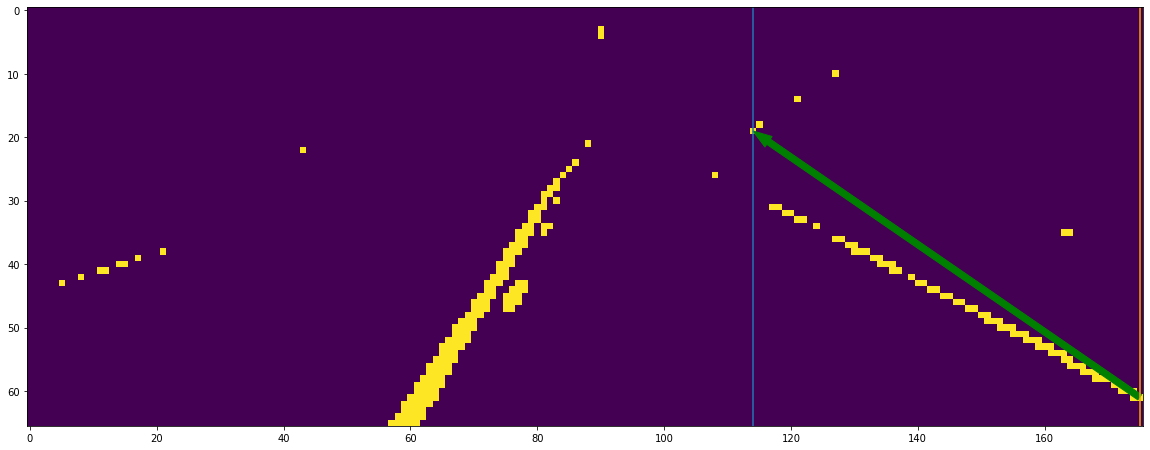

In [32]:
plotRight_hand(r"Images/Road3.jpg", r"Keys/Road3_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 37.35


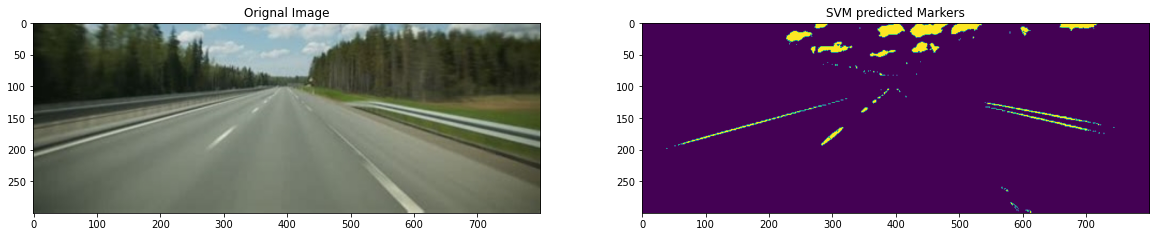

Left Bound: (742,165)
Rigth Bound: (743,165)
line angle 0.00 degrees
vector Equation
Slope: 0.00
B intercept: 165.00


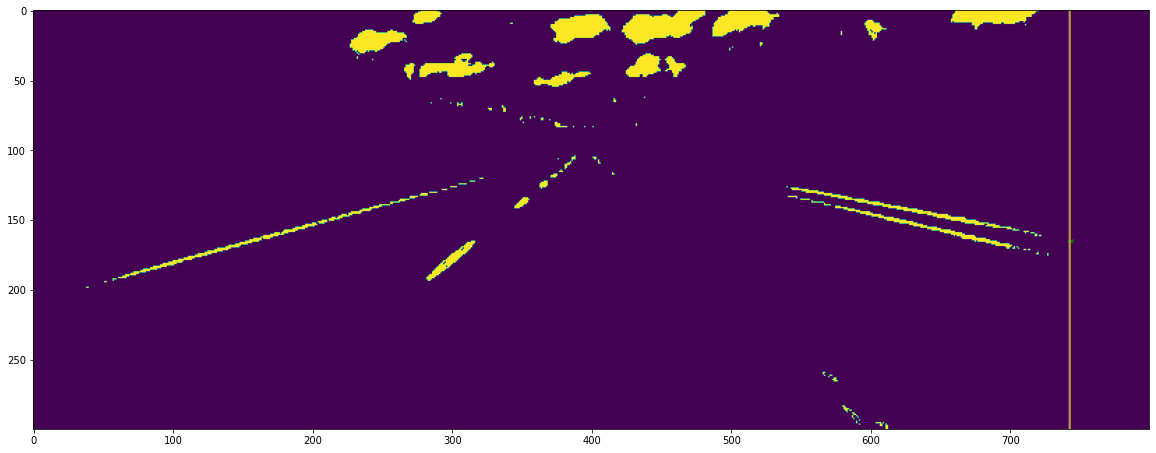

In [33]:
plotRight_hand(r"Images/Road4.jpg", r"Keys/Road4_key.jpg", svc_model, 1)

Time to bring in and predict image: 1.95


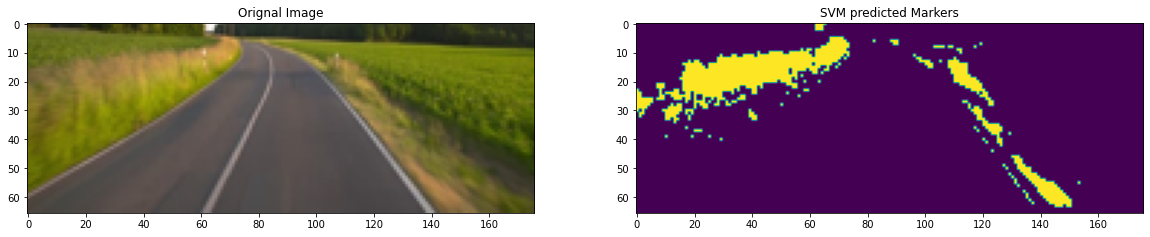

Left Bound: (96,11)
Rigth Bound: (153,55)
line angle -37.67 degrees
vector Equation
Slope: 0.77
B intercept: -63.11


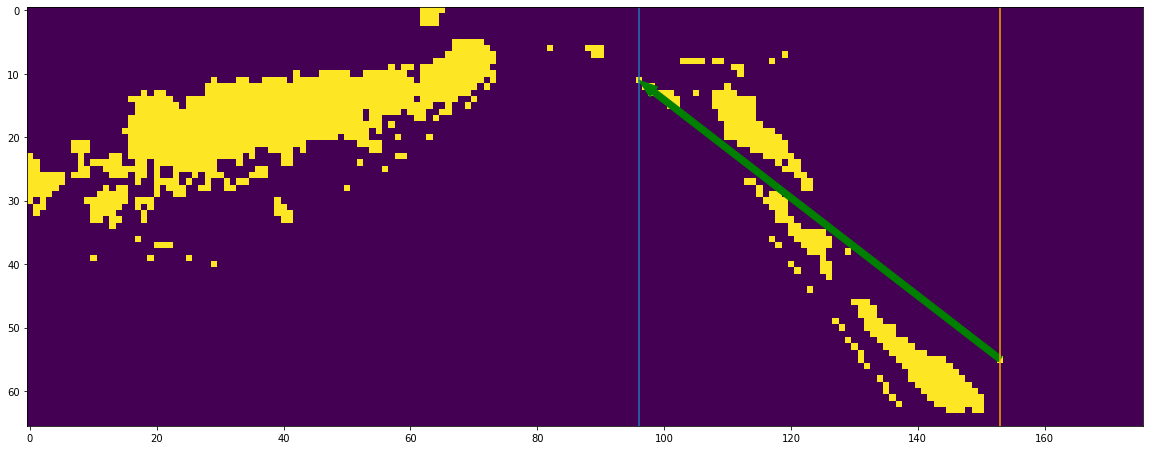

In [34]:
plotRight_hand(r"Images/Road5.jpg", r"Keys/Road5_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.86


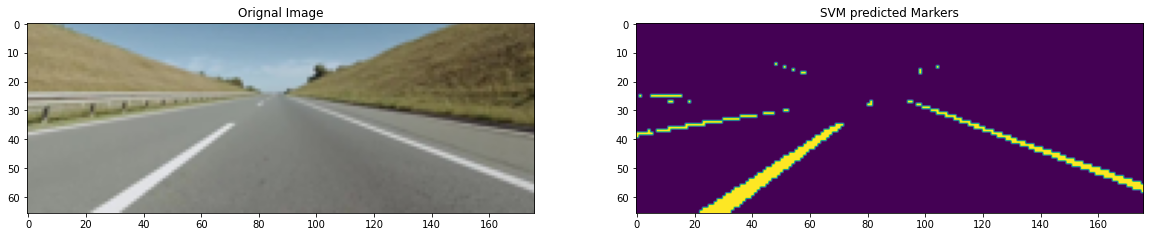

Left Bound: (94,27)
Rigth Bound: (175,58)
line angle -20.94 degrees
vector Equation
Slope: 0.38
B intercept: -8.98


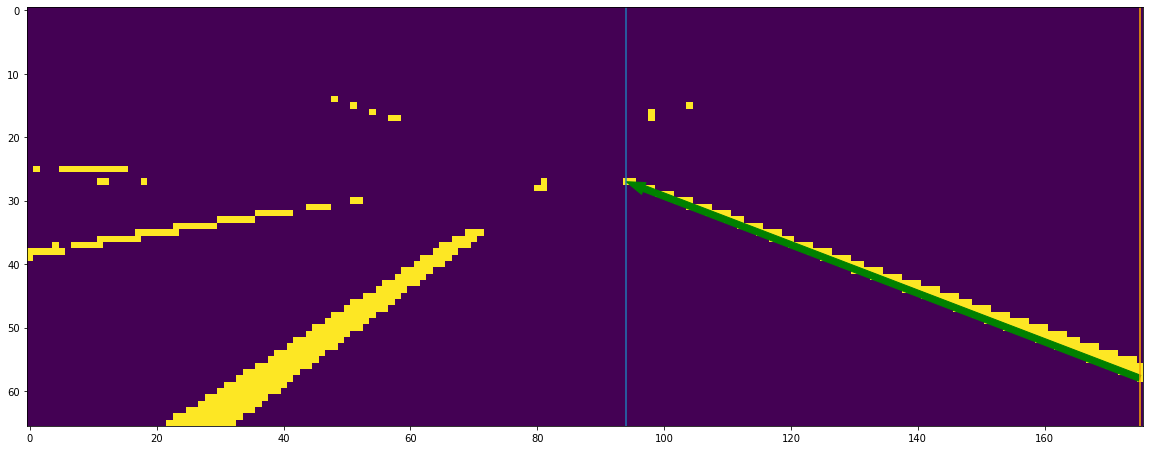

In [35]:
plotRight_hand(r"Images/Road6.jpg", r"Keys/Road6_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.84


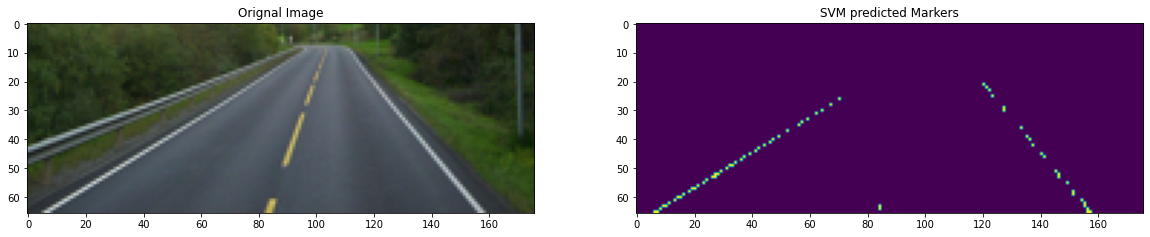

Left Bound: (133,36)
Rigth Bound: (157,65)
line angle -50.39 degrees
vector Equation
Slope: 1.21
B intercept: -124.71


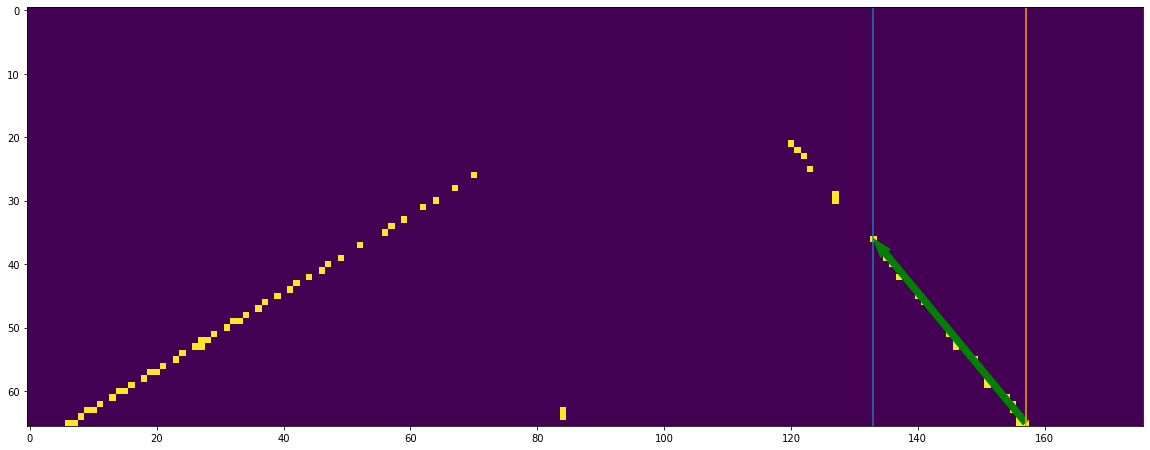

In [36]:
plotRight_hand(r"Images/Road7.jpg", r"Keys/Road7_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.81


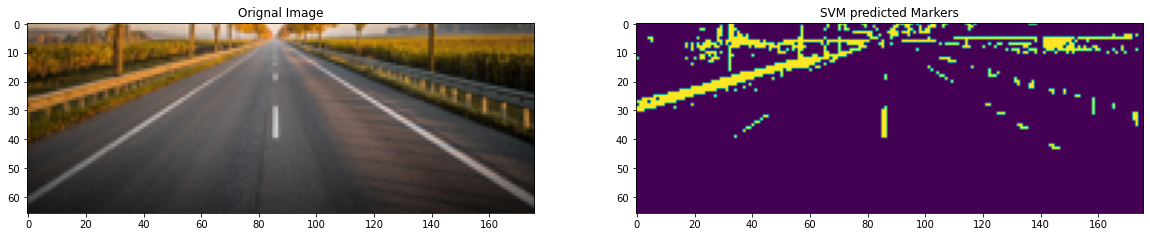

!!Error!! edges not found end set to mid point 0 0
Left Bound: (63,15)
Rigth Bound: (173,35)
line angle -10.30 degrees
vector Equation
Slope: 0.18
B intercept: 3.55


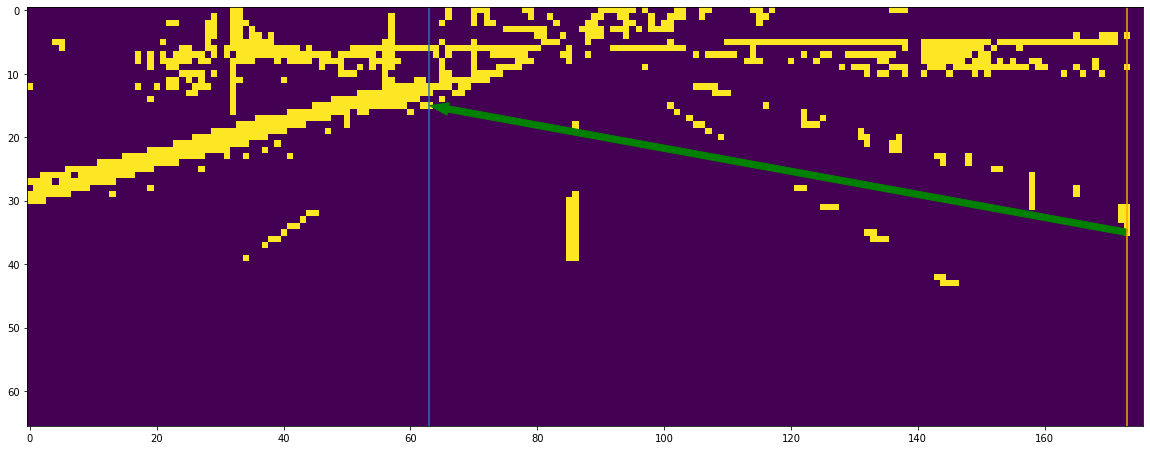

In [37]:
plotRight_hand(r"Images/Road8.jpg", r"Keys/Road8_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.81


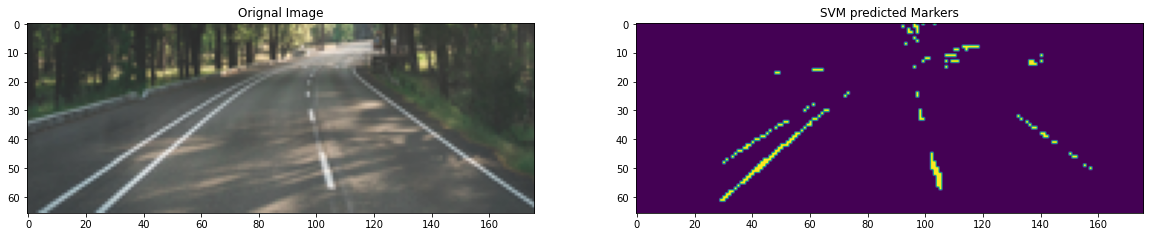

Left Bound: (132,32)
Rigth Bound: (157,50)
line angle -35.75 degrees
vector Equation
Slope: 0.72
B intercept: -63.04


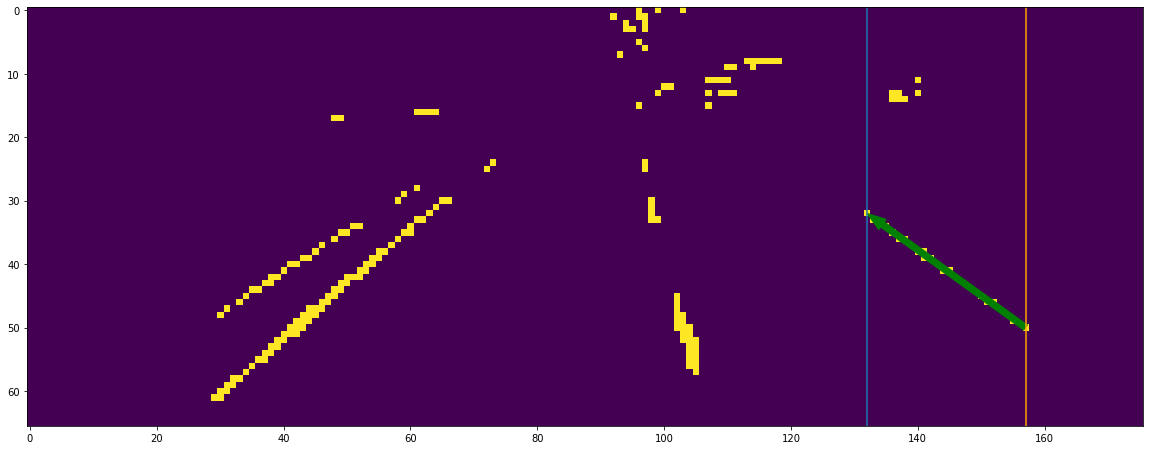

In [38]:
plotRight_hand(r"Images/Road9.jpg", r"Keys/Road9_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.84


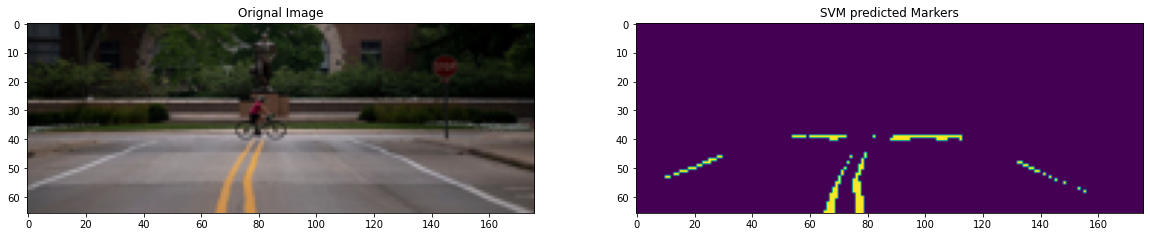

Left Bound: (132,48)
Rigth Bound: (155,58)
line angle -23.50 degrees
vector Equation
Slope: 0.43
B intercept: -9.39


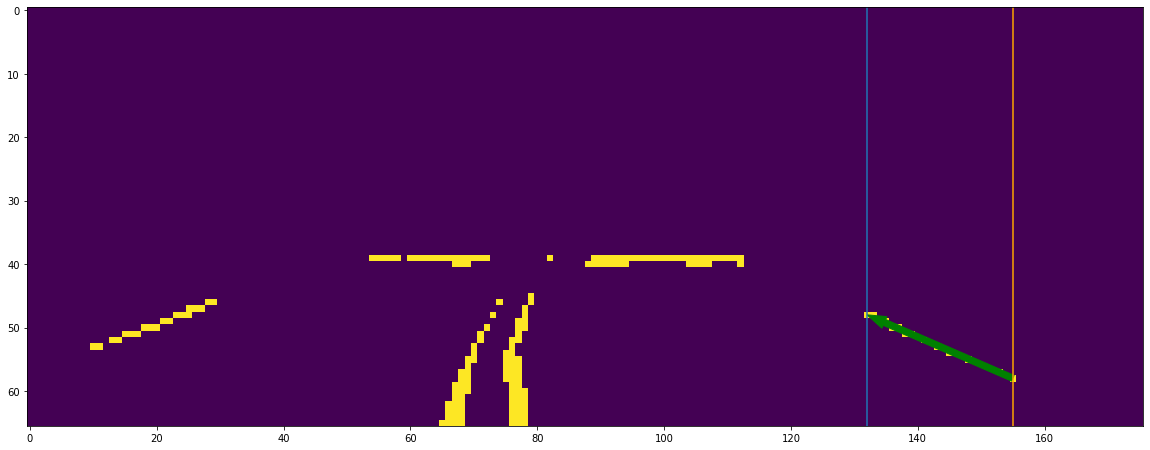

In [39]:
plotRight_hand(r"Images/Road10.jpg", r"Keys/Road10_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.84


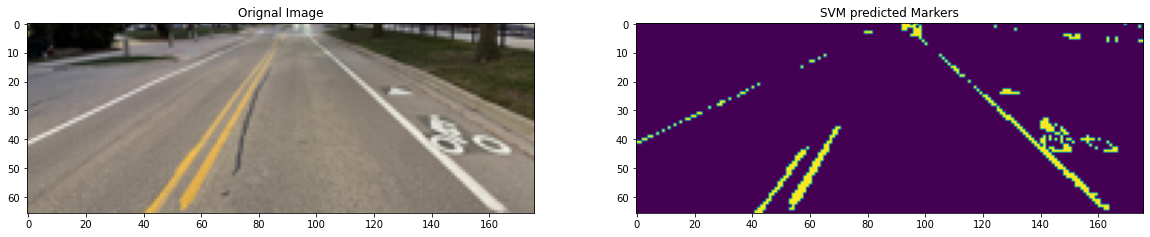

Left Bound: (174,1)
Rigth Bound: (175,6)
line angle -78.69 degrees
vector Equation
Slope: 5.00
B intercept: -869.00


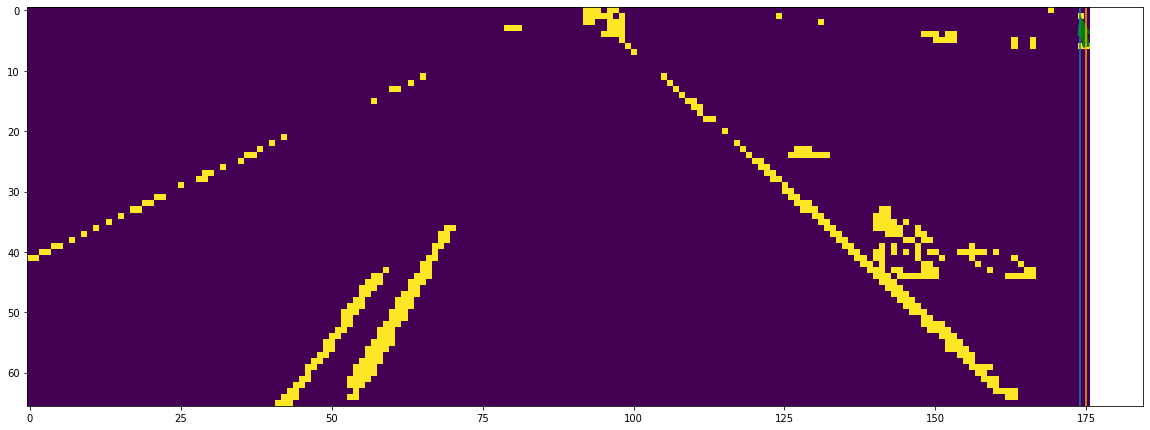

In [40]:
plotRight_hand(r"Images/Road11.jpg", r"Keys/Road11_key.jpg", svc_model, accuracy)

Time to bring in and predict image: 1.83


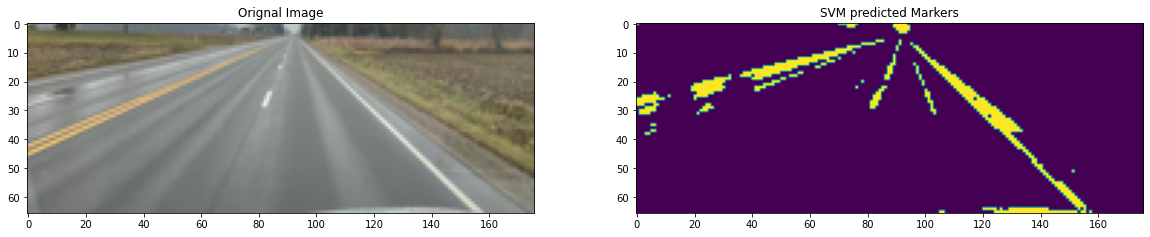

!!Error!! edges not found end set to mid point 0 0
Left Bound: (92,0)
Rigth Bound: (157,65)
line angle -45.00 degrees
vector Equation
Slope: 1.00
B intercept: -92.00


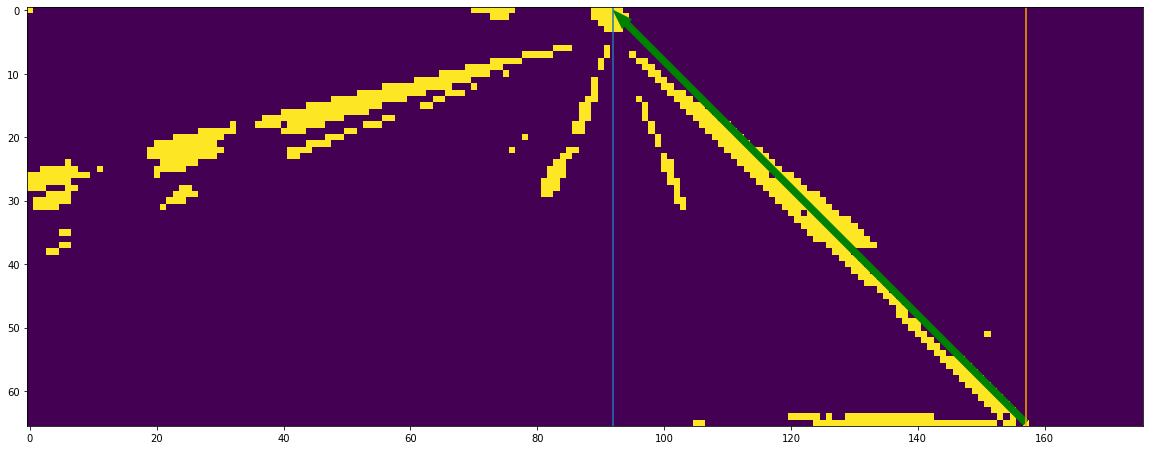

In [41]:
plotRight_hand(r"Images/Road12.jpg", r"Keys/Road12_key.jpg", svc_model, accuracy)

## Conclusion

Using the above demonstrated methods it is very possible to take in an image and from it find the right line vector. The method above shows 12 images that were brough in and produced a right line vector equation in under 4 seconds per image. However, this model shows to be highly sensitive to the suroundings of the road. Partictullay white and yellow tinted surroundings. In turn these falsely producted keys lead the right hand line to be incorrect. To improve on future versions the color of adjecent pixels to the pixel in question may be a beneifictal feature. Additionally, in future versions looking for both the left hand and the right hand line and using the better of the two may produce a more fault proof result. This project also shows that the quality of the photo can be reduced to 13% of the original photo and still produce a relativly sucessfull result. W